### Import

In [1]:
print(4+4)

8


In [2]:
import pandas as pd
import numpy as np
import gc

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

### Data Load

In [5]:
# 데이터 분할(폴더) 구분
data_splits = ["train", "test"]

# 각 데이터 유형별 폴더명, 파일 접미사, 변수 접두어 설정
data_categories = {
    "회원정보": {"folder": "1.회원정보", "suffix": "회원정보", "var_prefix": "customer"},
    "신용정보": {"folder": "2.신용정보", "suffix": "신용정보", "var_prefix": "credit"},
    "승인매출정보": {"folder": "3.승인매출정보", "suffix": "승인매출정보", "var_prefix": "sales"},
    "청구정보": {"folder": "4.청구입금정보", "suffix": "청구정보", "var_prefix": "billing"},
    "잔액정보": {"folder": "5.잔액정보", "suffix": "잔액정보", "var_prefix": "balance"},
    "채널정보": {"folder": "6.채널정보", "suffix": "채널정보", "var_prefix": "channel"},
    "마케팅정보": {"folder": "7.마케팅정보", "suffix": "마케팅정보", "var_prefix": "marketing"},
    "성과정보": {"folder": "8.성과정보", "suffix": "성과정보", "var_prefix": "performance"}
}

# 2018년 7월부터 12월까지의 월 리스트
months = ['07']

path = '/home/cksgh8511/키움/card/open'
for split in data_splits:
    for category, info in data_categories.items():
        folder = info["folder"]
        suffix = info["suffix"]
        var_prefix = info["var_prefix"]
        
        for month in months:
            # 파일명 형식: 2018{month}_{split}_{suffix}.parquet
            file_path = f"{path}/{split}/{folder}/2018{month}_{split}_{suffix}.parquet"
            # 변수명 형식: {var_prefix}_{split}_{month}
            variable_name = f"{var_prefix}_{split}_{month}"
            globals()[variable_name] = pd.read_parquet(file_path)
            print(f"{variable_name} is loaded from {file_path}")

gc.collect()

customer_train_07 is loaded from /home/cksgh8511/키움/card/open/train/1.회원정보/201807_train_회원정보.parquet


ArrowInvalid: Could not open Parquet input source '<Buffer>': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.

### Data Preprocessing(1) : Concat & Merge

In [26]:
# 데이터 유형별 설정 
info_categories = ["customer", "credit", "sales", "billing", "balance", "channel", "marketing", "performance"]

# 월 설정
months = ['07']
# months = ['07', '08', '09', '10', '11', '12']

In [27]:
#### Train ####

# 각 유형별로 월별 데이터를 합쳐서 새로운 변수에 저장
train_dfs = {}

for prefix in info_categories:
    # globals()에서 동적 변수명으로 데이터프레임들을 가져와 리스트에 저장
    df_list = [globals()[f"{prefix}_train_{month}"] for month in months]
    train_dfs[f"{prefix}_train_df"] = pd.concat(df_list, axis=0)
    gc.collect()
    print(f"{prefix}_train_df is created with shape: {train_dfs[f'{prefix}_train_df'].shape}")


customer_train_df = train_dfs["customer_train_df"]
credit_train_df   = train_dfs["credit_train_df"]
sales_train_df    = train_dfs["sales_train_df"]
billing_train_df  = train_dfs["billing_train_df"]
balance_train_df  = train_dfs["balance_train_df"]
channel_train_df  = train_dfs["channel_train_df"]
marketing_train_df= train_dfs["marketing_train_df"]
performance_train_df = train_dfs["performance_train_df"]

gc.collect()

customer_train_df is created with shape: (400000, 78)
credit_train_df is created with shape: (400000, 42)
sales_train_df is created with shape: (400000, 406)
billing_train_df is created with shape: (400000, 46)
balance_train_df is created with shape: (400000, 82)
channel_train_df is created with shape: (400000, 105)
marketing_train_df is created with shape: (400000, 64)
performance_train_df is created with shape: (400000, 49)


0

In [28]:
dfs = {
    "customer_train_df": customer_train_df,
    "credit_train_df": credit_train_df,
    "sales_train_df": sales_train_df,
    "billing_train_df": billing_train_df,
    "balance_train_df": balance_train_df,
    "channel_train_df": channel_train_df,
    "marketing_train_df": marketing_train_df,
    "performance_train_df": performance_train_df
}

# 각 데이터프레임의 컬럼 출력
for name, df in dfs.items():
    print(f"\n[{name} 컬럼 목록] ({df.shape[1]} columns)")
    print(df.columns.tolist())


[customer_train_df 컬럼 목록] (78 columns)
['기준년월', 'ID', '남녀구분코드', '연령', 'Segment', '회원여부_이용가능', '회원여부_이용가능_CA', '회원여부_이용가능_카드론', '소지여부_신용', '소지카드수_유효_신용', '소지카드수_이용가능_신용', '입회일자_신용', '입회경과개월수_신용', '회원여부_연체', '이용거절여부_카드론', '동의여부_한도증액안내', '수신거부여부_TM', '수신거부여부_DM', '수신거부여부_메일', '수신거부여부_SMS', '가입통신회사코드', '탈회횟수_누적', '최종탈회후경과월', '탈회횟수_발급6개월이내', '탈회횟수_발급1년이내', '거주시도명', '직장시도명', '마케팅동의여부', '유효카드수_신용체크', '유효카드수_신용', '유효카드수_신용_가족', '유효카드수_체크', '유효카드수_체크_가족', '이용가능카드수_신용체크', '이용가능카드수_신용', '이용가능카드수_신용_가족', '이용가능카드수_체크', '이용가능카드수_체크_가족', '이용카드수_신용체크', '이용카드수_신용', '이용카드수_신용_가족', '이용카드수_체크', '이용카드수_체크_가족', '이용금액_R3M_신용체크', '이용금액_R3M_신용', '이용금액_R3M_신용_가족', '이용금액_R3M_체크', '이용금액_R3M_체크_가족', '_1순위카드이용금액', '_1순위카드이용건수', '_1순위신용체크구분', '_2순위카드이용금액', '_2순위카드이용건수', '_2순위신용체크구분', '최종유효년월_신용_이용가능', '최종유효년월_신용_이용', '최종카드발급일자', '보유여부_해외겸용_본인', '이용가능여부_해외겸용_본인', '이용여부_3M_해외겸용_본인', '보유여부_해외겸용_신용_본인', '이용가능여부_해외겸용_신용_본인', '이용여부_3M_해외겸용_신용_본인', '연회비발생카드수_B0M', '연회비할인카드수_B0M', '기본연회비_B0M', '제휴연회비_B0M', '할인금액_기본연회비_B0M'

In [29]:
# 데이터프레임 딕셔너리
dfs = {
    "customer_train_df": customer_train_df,
    "credit_train_df": credit_train_df,
    "sales_train_df": sales_train_df,
    "billing_train_df": billing_train_df,
    "balance_train_df": balance_train_df,
    "channel_train_df": channel_train_df,
    "marketing_train_df": marketing_train_df,
    "performance_train_df": performance_train_df
}

# 결과 저장할 딕셔너리
constant_features_dict = {}

# 각 데이터프레임별로 상수 Feature 찾고 제거 (기준년월 제외)
for name, df in dfs.items():
    constant_features = [
        col for col in df.columns 
        if df[col].nunique() <= 1 and col != '기준년월'  # 기준년월은 제외
    ]
    constant_features_dict[name] = constant_features
    df.drop(columns=constant_features, inplace=True)
    
    print(f"[{name}] 상수 feature 개수 (기준년월 제외): {len(constant_features)}개")
    if constant_features:
        print(" -", constant_features)
    else:
        print(" - 없음")


[customer_train_df] 상수 feature 개수 (기준년월 제외): 9개
 - ['이용카드수_체크_가족', '이용금액_R3M_체크_가족', '연회비할인카드수_B0M', '할인금액_기본연회비_B0M', '할인금액_제휴연회비_B0M', '상품관련면제카드수_B0M', '임직원면제카드수_B0M', '우수회원면제카드수_B0M', '기타면제카드수_B0M']
[credit_train_df] 상수 feature 개수 (기준년월 제외): 1개
 - ['시장연체상환여부_R3M']
[sales_train_df] 상수 feature 개수 (기준년월 제외): 36개
 - ['이용건수_부분무이자_B0M', '이용금액_부분무이자_B0M', '여유_여행이용금액', '납부_렌탈료이용금액', '납부_유선방송이용금액', '납부_건강연금이용금액', '할부건수_부분_3M_R12M', '할부건수_부분_6M_R12M', '할부건수_부분_14M_R12M', '할부금액_부분_3M_R12M', '할부금액_부분_6M_R12M', 'RP건수_유선방송_B0M', 'RP건수_건강_B0M', 'RP후경과월_유선방송', 'RP후경과월_건강', '증감_RP건수_아파트_전월', '증감_RP건수_렌탈_전월', '증감_RP건수_보험_전월', '증감_RP건수_학습비_전월', '증감_RP건수_유선방송_전월', '증감_RP건수_건강_전월', '이용개월수_당사페이_R6M', '이용금액_당사페이_R6M', '이용금액_당사기타_R6M', '이용건수_당사페이_R6M', '이용건수_당사기타_R6M', '이용금액_당사페이_R3M', '이용금액_당사기타_R3M', '이용건수_당사페이_R3M', '이용건수_당사기타_R3M', '이용금액_당사페이_B0M', '이용금액_당사기타_B0M', '이용건수_당사페이_B0M', '이용건수_당사기타_B0M', '승인거절건수_입력오류_B0M', '승인거절건수_기타_B0M']
[billing_train_df] 상수 feature 개수 (기준년월 제외): 1개
 - ['대표결제방법코드']
[balan

In [30]:
customer_train_df.head()

,기준년월,ID,남녀구분코드,연령,Segment,회원여부_이용가능,회원여부_이용가능_CA,회원여부_이용가능_카드론,소지여부_신용,소지카드수_유효_신용,...,이용가능여부_해외겸용_신용_본인,이용여부_3M_해외겸용_신용_본인,연회비발생카드수_B0M,기본연회비_B0M,제휴연회비_B0M,청구금액_기본연회비_B0M,청구금액_제휴연회비_B0M,카드신청건수,Life_Stage,최종카드발급경과월
0,201807,TRAIN_000000,2,40대,D,1,1,0,1,1,...,0,0,0개,0,0,0,0,0,자녀성장(2),22
1,201807,TRAIN_000001,1,30대,E,1,1,1,1,1,...,0,0,0개,0,0,0,0,0,자녀성장(1),18
2,201807,TRAIN_000002,1,30대,C,1,1,0,1,1,...,0,0,0개,0,0,0,0,0,자녀출산기,20
3,201807,TRAIN_000003,2,40대,D,1,1,0,1,2,...,1,1,0개,0,0,0,0,1,자녀성장(2),17
4,201807,TRAIN_000004,2,40대,E,1,1,1,1,1,...,0,0,0개,0,0,0,0,1,자녀성장(1),15


In [31]:
#### Test ####

# test 데이터에 대해 train과 동일한 방법 적용
test_dfs = {}

for prefix in info_categories:
    df_list = [globals()[f"{prefix}_test_{month}"] for month in months]
    test_dfs[f"{prefix}_test_df"] = pd.concat(df_list, axis=0)
    gc.collect()
    print(f"{prefix}_test_df is created with shape: {test_dfs[f'{prefix}_test_df'].shape}")


customer_test_df = test_dfs["customer_test_df"]
credit_test_df   = test_dfs["credit_test_df"]
sales_test_df    = test_dfs["sales_test_df"]
billing_test_df  = test_dfs["billing_test_df"]
balance_test_df  = test_dfs["balance_test_df"]
channel_test_df  = test_dfs["channel_test_df"]
marketing_test_df= test_dfs["marketing_test_df"]
performance_test_df = test_dfs["performance_test_df"]

gc.collect()

customer_test_df is created with shape: (100000, 77)
credit_test_df is created with shape: (100000, 42)
sales_test_df is created with shape: (100000, 406)
billing_test_df is created with shape: (100000, 46)
balance_test_df is created with shape: (100000, 82)
channel_test_df is created with shape: (100000, 105)
marketing_test_df is created with shape: (100000, 64)
performance_test_df is created with shape: (100000, 49)


0

[0]	validation_0-mlogloss:1.08737	validation_1-mlogloss:1.08917
[1]	validation_0-mlogloss:0.83465	validation_1-mlogloss:0.83774
[2]	validation_0-mlogloss:0.67476	validation_1-mlogloss:0.67903
[3]	validation_0-mlogloss:0.56614	validation_1-mlogloss:0.57150
[4]	validation_0-mlogloss:0.48921	validation_1-mlogloss:0.49568
[5]	validation_0-mlogloss:0.43314	validation_1-mlogloss:0.44037
[6]	validation_0-mlogloss:0.39139	validation_1-mlogloss:0.39952
[7]	validation_0-mlogloss:0.35939	validation_1-mlogloss:0.36827
[8]	validation_0-mlogloss:0.33498	validation_1-mlogloss:0.34463
[9]	validation_0-mlogloss:0.31569	validation_1-mlogloss:0.32611
[10]	validation_0-mlogloss:0.30088	validation_1-mlogloss:0.31196
[11]	validation_0-mlogloss:0.28823	validation_1-mlogloss:0.30022
[12]	validation_0-mlogloss:0.27832	validation_1-mlogloss:0.29110
[13]	validation_0-mlogloss:0.26839	validation_1-mlogloss:0.28190
[14]	validation_0-mlogloss:0.26071	validation_1-mlogloss:0.27499
[15]	validation_0-mlogloss:0.25453	

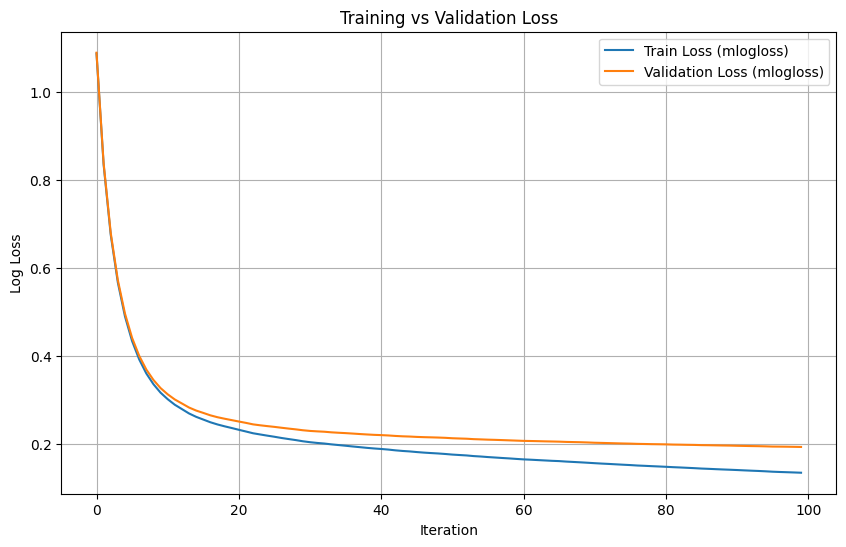

In [33]:
from sklearn.preprocessing import LabelEncoder

# (1) Feature/Target 분리
target_col = 'Segment'  # 네 데이터 맞게 수정
X = train_df.drop(columns=['기준년월', 'ID', target_col])
y = train_df[target_col]

# (2) X 데이터: object 타입 전부 Label Encoding
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))  # object → str 변환 후 Label Encoding

# (3) y 데이터: Label Encoding
le_y = LabelEncoder()
y = le_y.fit_transform(y)

# (4) Train/Validation split
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# (5) XGBoost 학습
import xgboost as xgb

model = xgb.XGBClassifier(
    tree_method='hist',
    max_bin=256,
    random_state=42,
    eval_metric='mlogloss'
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=True
)

# (6) 학습 결과 시각화
evals_result = model.evals_result()

train_loss = evals_result['validation_0']['mlogloss']
val_loss = evals_result['validation_1']['mlogloss']

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(train_loss, label='Train Loss (mlogloss)')
plt.plot(val_loss, label='Validation Loss (mlogloss)')
plt.xlabel('Iteration')
plt.ylabel('Log Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
#### Train ####

train_df = customer_train_df.merge(credit_train_df, on=['기준년월', 'ID'], how='left')


print("Step1 저장 완료: train_step1, shape:", train_df.shape)
del customer_train_df, credit_train_df
gc.collect()

# 이후 merge할 데이터프레임 이름과 단계 정보를 리스트에 저장
merge_list = [
    ("sales_train_df",    "Step2"),
    ("billing_train_df",  "Step3"),
    ("balance_train_df",  "Step4"),
    ("channel_train_df",  "Step5"),
    ("marketing_train_df","Step6"),
    ("performance_train_df", "최종")
]

# 나머지 단계 merge
for df_name, step in merge_list:
    # globals()로 동적 변수 접근하여 merge 수행
    train_df = train_df.merge(globals()[df_name], on=['기준년월', 'ID'], how='left')
    print(f"{step} 저장 완료: train_{step}, shape:", train_df.shape)
    # 사용한 변수는 메모리 해제를 위해 삭제
    del globals()[df_name]
    gc.collect()

Step1 저장 완료: train_step1, shape: (800000, 118)
Step2 저장 완료: train_Step2, shape: (800000, 522)
Step3 저장 완료: train_Step3, shape: (800000, 566)
Step4 저장 완료: train_Step4, shape: (800000, 646)
Step5 저장 완료: train_Step5, shape: (800000, 749)
Step6 저장 완료: train_Step6, shape: (800000, 811)
최종 저장 완료: train_최종, shape: (800000, 858)


In [17]:
train_df.columns

Index(['기준년월', 'ID', '남녀구분코드', '연령', 'Segment', '회원여부_이용가능', '회원여부_이용가능_CA',
       '회원여부_이용가능_카드론', '소지여부_신용', '소지카드수_유효_신용',
       ...
       '변동률_RV일시불평잔', '변동률_할부평잔', '변동률_CA평잔', '변동률_RVCA평잔', '변동률_카드론평잔',
       '변동률_잔액_B1M', '변동률_잔액_일시불_B1M', '변동률_잔액_CA_B1M', '혜택수혜율_R3M',
       '혜택수혜율_B0M'],
      dtype='object', length=858)

In [ ]:
train_df.drop(columns=)

In [13]:
#### Test ####

test_df = customer_test_df.merge(credit_test_df, on=['기준년월', 'ID'], how='left')
print("Step1 저장 완료: test_step1, shape:", test_df.shape)
del customer_test_df, credit_test_df
gc.collect()

# 이후 merge할 데이터프레임 이름과 단계 정보를 리스트에 저장
merge_list = [
    ("sales_test_df",    "Step2"),
    ("billing_test_df",  "Step3"),
    ("balance_test_df",  "Step4"),
    ("channel_test_df",  "Step5"),
    ("marketing_test_df","Step6"),
    ("performance_test_df", "최종")
]

# 나머지 단계 merge
for df_name, step in merge_list:
    # globals()로 동적 변수 접근하여 merge 수행
    test_df = test_df.merge(globals()[df_name], on=['기준년월', 'ID'], how='left')
    print(f"{step} 저장 완료: test_{step}, shape:", test_df.shape)
    # 사용한 변수는 메모리 해제를 위해 삭제
    del globals()[df_name]
    gc.collect()

Step1 저장 완료: test_step1, shape: (100000, 117)
Step2 저장 완료: test_Step2, shape: (100000, 521)
Step3 저장 완료: test_Step3, shape: (100000, 565)
Step4 저장 완료: test_Step4, shape: (100000, 645)
Step5 저장 완료: test_Step5, shape: (100000, 748)
Step6 저장 완료: test_Step6, shape: (100000, 810)
최종 저장 완료: test_최종, shape: (100000, 857)


### Data Preprocessing(2) : Encoding

In [14]:
feature_cols = [col for col in train_df.columns if col not in ["ID", "Segment"]]

X = train_df[feature_cols].copy()
y = train_df["Segment"].copy()

# 타깃 라벨 인코딩
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

In [15]:
y

0         D
1         E
2         C
3         D
4         E
         ..
399995    E
399996    D
399997    C
399998    E
399999    E
Name: Segment, Length: 400000, dtype: object

In [16]:
print(len(feature_cols))

856


In [17]:
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

X_test = test_df.copy()

encoders = {}  # 각 컬럼별 encoder 저장

for col in categorical_features:
    le_train = LabelEncoder()
    X[col] = le_train.fit_transform(X[col])
    encoders[col] = le_train
    unseen_labels_val = set(X_test[col]) - set(le_train.classes_)
    if unseen_labels_val:
        le_train.classes_ = np.append(le_train.classes_, list(unseen_labels_val))
    X_test[col] = le_train.transform(X_test[col])

In [18]:
gc.collect()

0

### Train

In [19]:
# try:
#     model = xgb.XGBClassifier(
#         tree_method='gpu_hist',  # GPU 모드 설정
#         gpu_id=0,
#         random_state=42
#     )
#     print("GPU 사용 가능: gpu_hist 모드 적용")
#     model.fit(X, y_encoded)
    
# except Exception:
#     model = xgb.XGBClassifier(
#         random_state=42
#     )
#     print("GPU 사용 불가: CPU 모드 적용")
#     model.fit(X, y_encoded)

c:\Users\키움디지털아카데미\Downloads\open\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:50:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\키움디지털아카데미\Downloads\open\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:50:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\키움디지털아카데미\Downloads\open\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:50:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\키움디지털아카데미\Downloads\open\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:50:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\s

GPU 사용 실패, CPU로 재설정합니다.
[0]	validation_0-mlogloss:1.08766
[1]	validation_0-mlogloss:0.83504
[2]	validation_0-mlogloss:0.67563
[3]	validation_0-mlogloss:0.56712
[4]	validation_0-mlogloss:0.49037
[5]	validation_0-mlogloss:0.43445
[6]	validation_0-mlogloss:0.39257
[7]	validation_0-mlogloss:0.36107
[8]	validation_0-mlogloss:0.33657
[9]	validation_0-mlogloss:0.31785
[10]	validation_0-mlogloss:0.30296
[11]	validation_0-mlogloss:0.29089
[12]	validation_0-mlogloss:0.28011
[13]	validation_0-mlogloss:0.27104
[14]	validation_0-mlogloss:0.26408
[15]	validation_0-mlogloss:0.25733
[16]	validation_0-mlogloss:0.25207
[17]	validation_0-mlogloss:0.24718
[18]	validation_0-mlogloss:0.24309
[19]	validation_0-mlogloss:0.23814
[20]	validation_0-mlogloss:0.23460
[21]	validation_0-mlogloss:0.23121
[22]	validation_0-mlogloss:0.22843
[23]	validation_0-mlogloss:0.22539
[24]	validation_0-mlogloss:0.22256
[25]	validation_0-mlogloss:0.22011
[26]	validation_0-mlogloss:0.21784
[27]	validation_0-mlogloss:0.21546
[28]	v

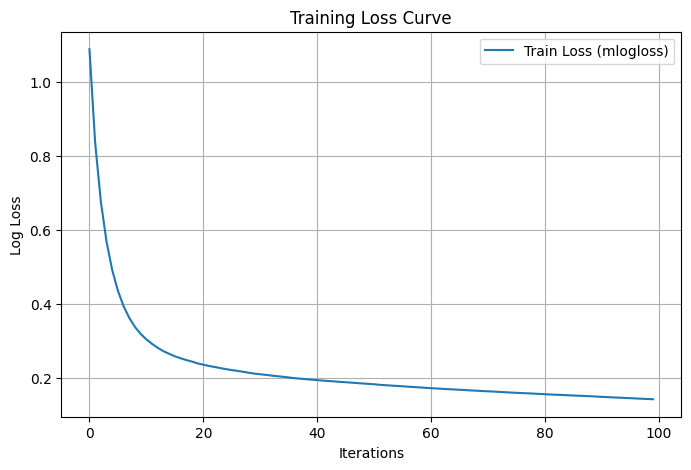

In [20]:
import xgboost as xgb
import matplotlib.pyplot as plt

# (1) 일단 GPU 설정 시도
model = xgb.XGBClassifier(
    tree_method='gpu_hist',  
    gpu_id=0,
    random_state=42,
    eval_metric='mlogloss'
)

try:
    model.fit(
        X, y_encoded,
        eval_set=[(X, y_encoded)],
        verbose=True
    )
except xgb.core.XGBoostError:
    print("GPU 사용 실패, CPU로 재설정합니다.")
    # (2) GPU 실패했으면 CPU 설정
    model = xgb.XGBClassifier(
        tree_method='hist',   # CPU 전용
        random_state=42,
        eval_metric='mlogloss'
    )
    model.fit(
        X, y_encoded,
        eval_set=[(X, y_encoded)],
        verbose=True
    )

# 학습 완료 후 결과 가져오기
evals_result = model.evals_result()

# loss curve 그리기
train_loss = evals_result['validation_0']['mlogloss']

plt.figure(figsize=(8,5))
plt.plot(train_loss, label='Train Loss (mlogloss)')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# model.fit(X, y_encoded)

### Predict

In [20]:
X_test.drop(columns=['ID'],inplace=True)

In [21]:
# row-level 예측 수행
y_test_pred = model.predict(X_test)
# 예측 결과를 변환
y_test_pred_labels = le_target.inverse_transform(y_test_pred)

# row 단위 예측 결과를 test_data에 추가
test_data = test_df.copy()  # 원본 유지
test_data["pred_label"] = y_test_pred_labels

In [ ]:
test_data["pred_label"]


### Submission

In [22]:
submission = test_data.groupby("ID")["pred_label"] \
    .agg(lambda x: x.value_counts().idxmax()) \
    .reset_index()

submission.columns = ["ID", "Segment"]

In [23]:
submission.to_csv('./base_submit.csv',index=False)